In [1]:
# set environment and import packages
import os
from pandas import read_csv
import pandas as pd
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns
# import local python modules
import constants as c
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')


plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

# mapping FAF mode to SynthFirm mode
mode_lookup = {1: 'Truck', 2: 'Rail', 3: 'Other', 4: 'Air', 
               5: 'Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

#define scenario input
analysis_year = 2040
shipment_load_attr = 'tons_' + str(analysis_year)
shipment_tonmile_attr = 'tmiles_' + str(analysis_year)

This section load FAF data, aggregated CFS data, SCTG definition and geographic boundaries of study area

In [2]:
#load modeled, FAF and CFS results
# print(c.cfs_distribution_file)
faf_data = read_csv(c.output_dir + c.faf_version_4_file, sep = ',')
modeled_data = read_csv(c.output_dir + c.modeled_file, sep = ',')
modeled_data = modeled_data.loc[modeled_data['mode_choice'] != 'Other']
#load parameters
sctg_group_lookup = read_csv(c.param_dir + c.sctg_group_lookup_file, sep = ',')
mesozone_lookup = read_csv(c.param_dir + c.mesozone_id_lookup_file, sep = ',')
sctg_definition = read_csv(c.param_dir + c.sctg_definition_file, sep = ',')
sctg_names = sctg_group_lookup['SCTG_Name'].unique()
sctg_group_definition = sctg_group_lookup.loc[:, ['SCTG_Group', 'SCTG_Name']]
sctg_group_definition = sctg_group_definition.drop_duplicates()

In [3]:
# process faf data for validation
faf_data.loc[:, 'mode_def'] = faf_data.loc[:, 'dms_mode'].map(mode_lookup)
faf_data = pd.merge(faf_data, sctg_definition, left_on = 'sctg2', right_on = 'SCTG', how = 'left')
faf_data = pd.merge(faf_data, sctg_group_lookup, left_on = 'sctg2', right_on = 'SCTG_Code', how = 'left')
pd.options.mode.chained_assignment = None  # default='warn', turn off annoy warning messages
faf_data.loc[:, 'Distance'] = 1000 * faf_data.loc[:, shipment_tonmile_attr] / faf_data.loc[:, shipment_load_attr]
faf_data.loc[:, shipment_tonmile_attr] *= 1000000 
faf_data = faf_data.dropna(subset = ['Distance'])
faf_data_domestic = faf_data.loc[faf_data['trade_type'] == c.trade_type_id] #select domestic shipment only
bay_area_outflow = faf_data_domestic.loc[faf_data_domestic['dms_orig'].isin(c.region_code)]
bay_area_inflow = faf_data_domestic.loc[faf_data_domestic['dms_dest'].isin(c.region_code)]
faf_data.head(5)

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,...,tmiles_2045,tmiles_2050,mode_def,SCTG,Description_x,SCTG_Code,SCTG_Group,SCTG_Name,Description_y,Distance
0,NaN,11,11,NaN,NaN,1,NaN,1,1,1,...,9.571647,11.343818,Truck,1,Animals and Fish (live),1,3,interm_food,Animals and Fish (live),62.055467
1,NaN,11,19,NaN,NaN,1,NaN,1,1,2,...,116.602924,134.683927,Truck,1,Animals and Fish (live),1,3,interm_food,Animals and Fish (live),124.036281
2,NaN,11,129,NaN,NaN,1,NaN,1,1,3,...,0.750361,0.844720,Truck,1,Animals and Fish (live),1,3,interm_food,Animals and Fish (live),325.380006
3,NaN,11,131,NaN,NaN,1,NaN,1,1,2,...,3.850035,4.178881,Truck,1,Animals and Fish (live),1,3,interm_food,Animals and Fish (live),171.440007
4,NaN,11,139,NaN,NaN,1,NaN,1,1,2,...,2.456208,2.683008,Truck,1,Animals and Fish (live),1,3,interm_food,Animals and Fish (live),244.231744


In [4]:
# process modeled data
# modeled_data.loc[:, 'Distance'] = modeled_data.loc[:, 'tmiles'] / 1000 / modeled_data.loc[:, 'ShipmentLoad']
modeled_bay_area_outflow = modeled_data.loc[modeled_data['outbound'] == 1]
modeled_bay_area_inflow = modeled_data.loc[modeled_data['inbound'] == 1]
modeled_data.head(5)

,Unnamed: 0,orig_FAFID,orig_FAFNAME,dest_FAFID,dest_FAFNAME,SCTG_Group,SCTG_Name,mode_choice,tmiles,ShipmentLoad,count,outbound,inbound,Distance
0,0,11,Birmingham,481,Austin,1,bulk,For-hire Truck,1.081429e+06,1.260760,52,0,1,857.760000
1,1,11,Birmingham,481,Austin,1,bulk,Rail/IMX,1.206135e+05,0.121227,5,0,1,994.940199
2,2,11,Birmingham,481,Austin,3,interm_food,For-hire Truck,5.619635e+06,6.551524,306,0,1,857.760000
3,3,11,Birmingham,481,Austin,3,interm_food,Rail/IMX,1.491475e+05,0.149906,7,0,1,994.940199
4,4,11,Birmingham,481,Austin,4,mfr_goods,For-hire Truck,4.120460e+06,4.803745,638,0,1,857.760000


interm_food


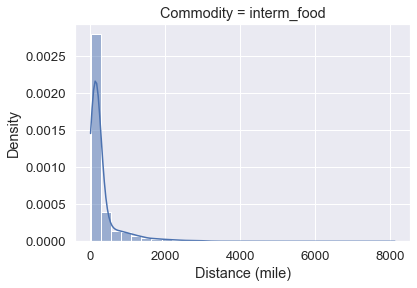

bulk


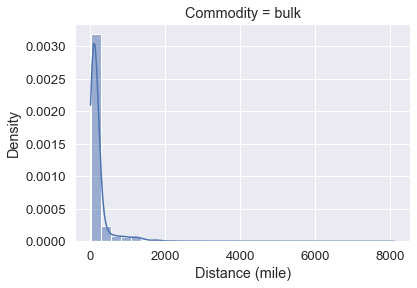

mfr_goods


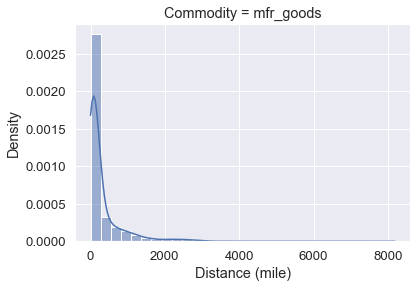

fuel_fert


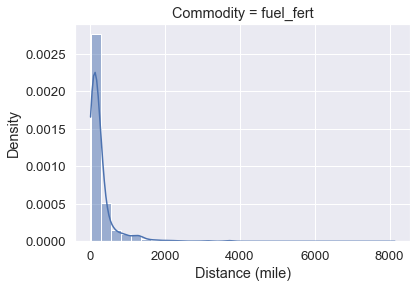

other


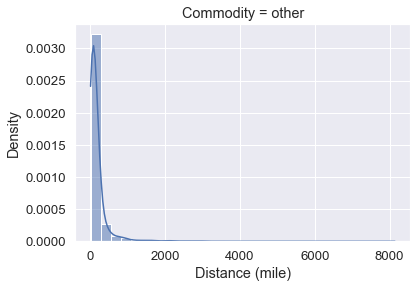

In [5]:
# generate FAF data descriptive statistics by commodity group
summary_statistics = {}
def summary_statistics_generator(data, tonmile_unit_factor = 1000000, shipment_load_unit_factor = 1000, 
                                 distance_var = 'Distance', load_var = 'weight', tonmile_var = 'tmiles'):
    mean_distance = (data[tonmile_var].sum() * tonmile_unit_factor) / \
    (data[load_var].sum() * shipment_load_unit_factor)
    max_distance = data.loc[data[load_var]>0, distance_var].max()
    min_distance = data.loc[data[load_var]>0, distance_var].min()
    data = data.sort_values(distance_var)
    data['weight'] = data[load_var].cumsum()
    cutoff = data[load_var].sum() / 2.0
    median_distance = data.loc[data['weight'] >= cutoff, distance_var].min()
    total_shipment_load = shipment_load_unit_factor * data[load_var].sum() # tons
    return(min_distance, max_distance, mean_distance, median_distance, total_shipment_load)
    
for sctg in sctg_names:
    print(sctg)
    faf_data_to_describe = faf_data_domestic.loc[faf_data_domestic['SCTG_Name'] == sctg]
    min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
    summary_statistics_generator(faf_data_to_describe, 1000000, 1000, 
                                 'Distance', shipment_load_attr, shipment_tonmile_attr)
    summary_statistics[sctg] = [min_distance, max_distance, mean_distance, median_distance]
    sns.histplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, bins = 30, 
             stat="density", kde = True, alpha=0.5)
    plt.title('Commodity = ' + sctg)
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.savefig('Plot_aus_2040/distance_distribution_for ' + sctg + '.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
summary_statistics_df = pd.DataFrame.from_dict(summary_statistics, orient='index',
                        columns=['min', 'max', 'mean', 'median']) 
summary_statistics_df.to_csv(c.output_dir + 'FAF_distance_statistics_by_sctg.csv')


In this section, we will compare shipment generation from FAF data, CFS data and modeled shipment data generated by SynthFirm. 

    -FAF: Only domestic shipment data will be selected from FAF.  
    -CFS: same aggregation level as FAF
    -SynthFirm: The SynthFirm modeled data will be filtered by study area.  The truck load will be scaled back to reflect the total shipment from all modes.

Truck


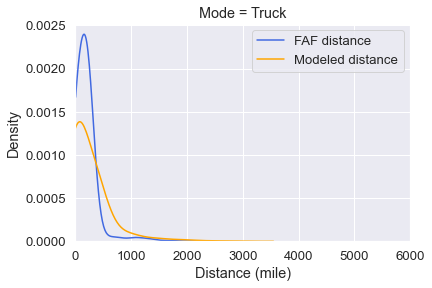

Rail


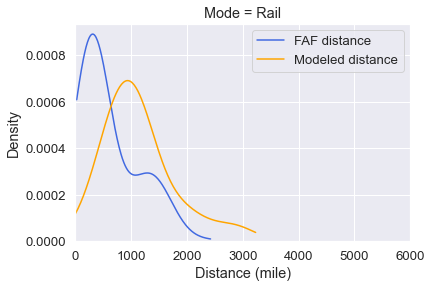

Air


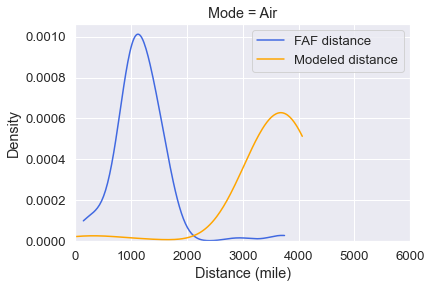

Parcel


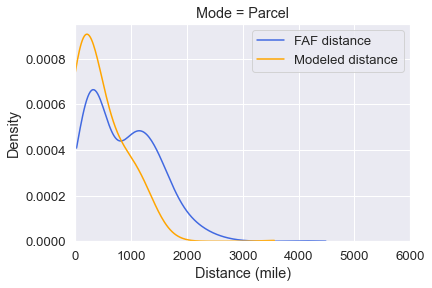

Truck


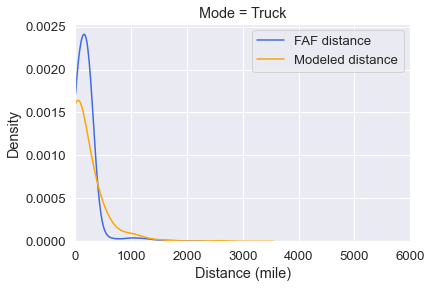

Rail


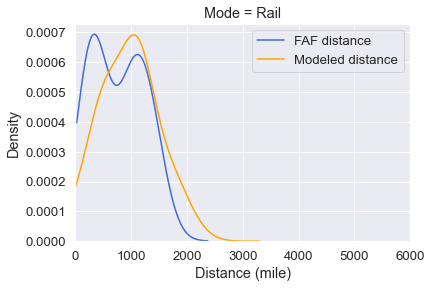

Air


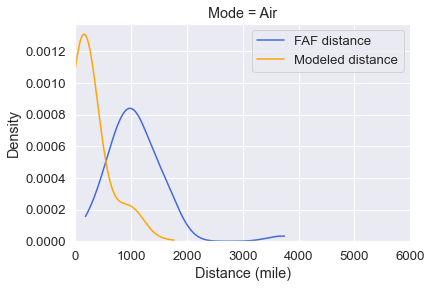

Parcel


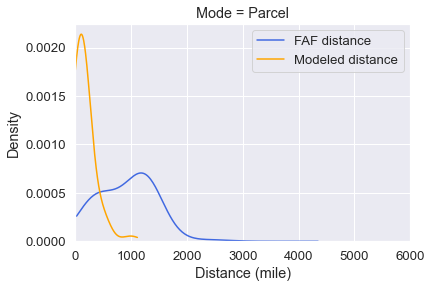

In [6]:
# compare travel distance by mode
modeled_statistics_mode = {}
FAF_mode_mapping = {'Truck':['For-hire Truck', 'Private Truck'], 'Rail':['Rail/IMX'], 
                    'Air': ['Air'], 'Parcel':['Parcel']}

mode_choice = modeled_data['mode_choice'].unique()


# production
modeled_statistics_mode = {}
for mode in ['Truck', 'Rail', 'Air', 'Parcel']:
    print(mode)
    mode_to_select = FAF_mode_mapping[mode]
    modeled_data_to_describe = modeled_bay_area_outflow.loc[modeled_bay_area_outflow['mode_choice'].isin(mode_to_select)]
#     min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
#     summary_statistics_generator(modeled_data_to_describe, 1, 1000, 
#                                  'Distance', 'ShipmentLoad', 'tmiles')
#     modeled_statistics_mode[mode] = [min_distance, max_distance, mean_distance, median_distance, total_shipment_load]
    
    faf_data_to_describe = bay_area_outflow.loc[bay_area_outflow['mode_def'] == mode]
    sns.kdeplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, cut = 0,
            color = 'royalblue')     
    sns.kdeplot(data = modeled_data_to_describe, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
            color = 'orange')
    plt.xlim([0, 6000])
    plt.legend(['FAF distance', 'Modeled distance'])
    plt.title('Mode = ' + mode)
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.savefig('Plot_aus_2040/outflow_distance_comparison_for ' + mode + '.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
# modeled_statistics_mode_df = pd.DataFrame.from_dict(modeled_statistics_mode, orient='index',
#                         columns=['min', 'max', 'mean', 'median', 'load (ton)']) 
# modeled_statistics_mode_df.to_csv(c.output_dir + 'modeled_outflow_distance_statistics_by_mode.csv')

# attraction
for mode in ['Truck', 'Rail', 'Air', 'Parcel']:
    print(mode)
    mode_to_select = FAF_mode_mapping[mode]
    modeled_data_to_describe = modeled_bay_area_inflow.loc[modeled_bay_area_inflow['mode_choice'].isin(mode_to_select)]
#     min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
#     summary_statistics_generator(modeled_data_to_describe, 1, 1000, 
#                                  'Distance', 'ShipmentLoad', 'tmiles')
#     modeled_statistics_mode[mode] = [min_distance, max_distance, mean_distance, median_distance, total_shipment_load]
    
    faf_data_to_describe = bay_area_inflow.loc[bay_area_inflow['mode_def'] == mode]
    sns.kdeplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, cut = 0,
             color = 'royalblue')  
    sns.kdeplot(data = modeled_data_to_describe, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
             color = 'orange')
    plt.xlim([0, 6000])
    plt.legend(['FAF distance', 'Modeled distance'])
    plt.title('Mode = ' + mode)
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.savefig('Plot_aus_2040/inflow_distance_comparison_for ' + mode + '.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
# modeled_statistics_mode_df = pd.DataFrame.from_dict(modeled_statistics_mode, orient='index',
#                         columns=['min', 'max', 'mean', 'median', 'load (ton)']) 
# modeled_statistics_mode_df.to_csv(c.output_dir + 'modeled_inflow_distance_statistics_by_mode.csv')

FAF shipment        1.354165e+06
Modeled shipment    1.235424e+06
dtype: float64
FAF tonmile        370753.171414
Modeled tonmile    588728.437659
dtype: float64


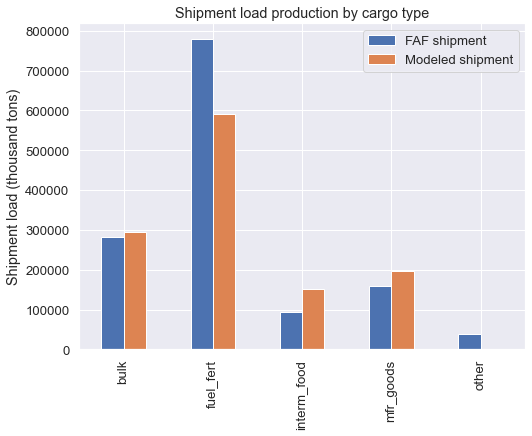

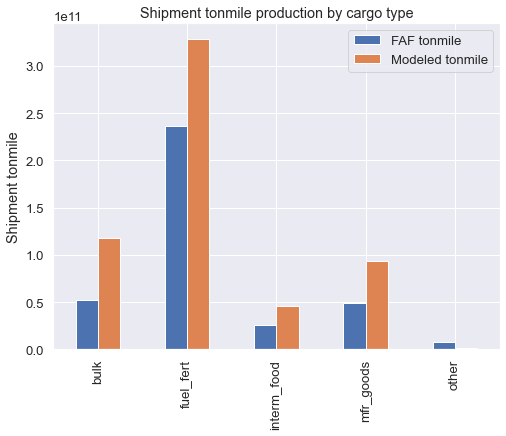

In [7]:
### plot shipment generation by commodity group
# data aggregation
FAF_shipment_by_sctg = bay_area_outflow.groupby('SCTG_Name')[[shipment_load_attr, shipment_tonmile_attr]].sum()
modeled_shipment_by_sctg = modeled_bay_area_outflow.groupby('SCTG_Name')[['ShipmentLoad', 'tmiles']].sum()

shipment_generation_by_sctg = pd.merge(FAF_shipment_by_sctg, modeled_shipment_by_sctg, 
                                       left_index = True, right_index = True, how = 'left')
shipment_generation_by_sctg.columns = ['FAF shipment', 'FAF tonmile', 
                                       'Modeled shipment', 'Modeled tonmile']
print(shipment_generation_by_sctg.loc[:, ['FAF shipment', 'Modeled shipment']].sum())
print(shipment_generation_by_sctg.loc[:, ['FAF tonmile', 'Modeled tonmile']].sum()/1000000)
# plot bar chart
shipment_generation_by_sctg.plot(y = ['FAF shipment', 'Modeled shipment'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment load production by cargo type')
plt.xlabel('')
plt.ylabel('Shipment load (thousand tons)')
plt.legend(loc=1)
plt.savefig('Plot_aus_2040/' + 'outflow_shipment_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()


shipment_generation_by_sctg.plot(y = ['FAF tonmile', 'Modeled tonmile'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment tonmile production by cargo type')
plt.xlabel('')
plt.ylabel('Shipment tonmile')
plt.legend(loc=1)
plt.savefig('Plot_aus_2040/' + 'outflow_tonmile_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()

FAF shipment        1.027479e+06
Modeled shipment    8.841419e+05
dtype: float64
FAF tonmile        269277.869363
Modeled tonmile    253997.948560
dtype: float64


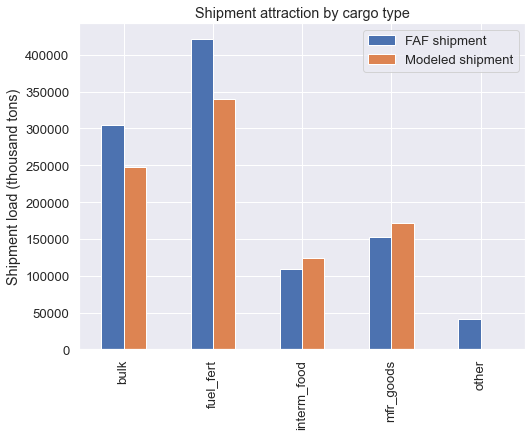

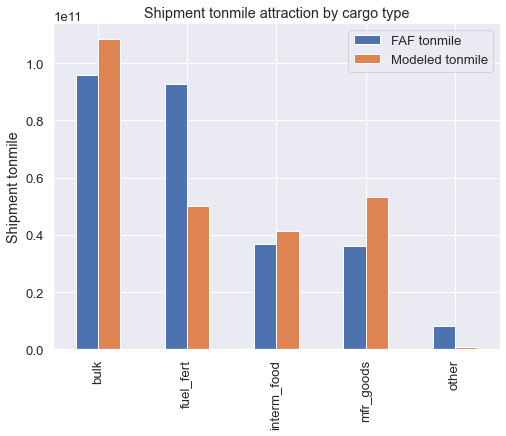

In [8]:
### plot shipment generation by commodity group
# data aggregation

FAF_shipment_by_sctg = bay_area_inflow.groupby('SCTG_Name')[[shipment_load_attr, shipment_tonmile_attr]].sum()
modeled_shipment_by_sctg = modeled_bay_area_inflow.groupby('SCTG_Name')[['ShipmentLoad', 'tmiles']].sum()


shipment_attraction_by_sctg = pd.merge(FAF_shipment_by_sctg, modeled_shipment_by_sctg, 
                                       left_index = True, right_index = True, how = 'left')
shipment_attraction_by_sctg.columns = ['FAF shipment', 'FAF tonmile', 
                                       'Modeled shipment', 'Modeled tonmile']

print(shipment_attraction_by_sctg.loc[:, ['FAF shipment', 'Modeled shipment']].sum())
print(shipment_attraction_by_sctg.loc[:, ['FAF tonmile', 'Modeled tonmile']].sum()/1000000)
# plot bar chart
shipment_attraction_by_sctg.plot(y = ['FAF shipment',  'Modeled shipment'], 
                                 figsize = (8, 6), kind = 'bar',  title = 'Shipment attraction by cargo type')
plt.xlabel('')
plt.ylabel('Shipment load (thousand tons)')
plt.legend(loc=1)
plt.savefig('Plot_aus_2040/' + 'inflow_shipment_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()

shipment_attraction_by_sctg.plot(y = ['FAF tonmile', 'Modeled tonmile'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment tonmile attraction by cargo type')
plt.xlabel('')
plt.ylabel('Shipment tonmile')
plt.legend(loc=1)
plt.savefig('Plot_aus_2040/' + 'inflow_tonmile_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()

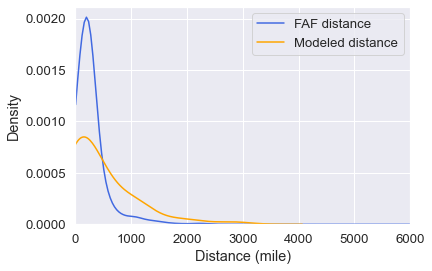

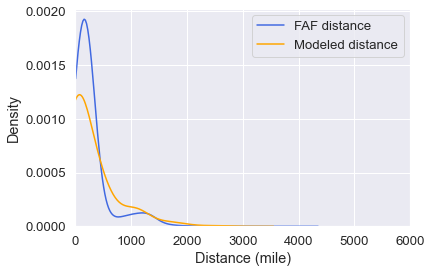

In [9]:
#KDE plot
sns.kdeplot(data = bay_area_outflow, x= 'Distance', weights = shipment_load_attr, cut = 0,
             color = 'royalblue')  
sns.kdeplot(data = modeled_bay_area_outflow, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
             color = 'orange')
plt.xlim([0, 6000])
plt.legend(['FAF distance', 'Modeled distance'])
plt.xlabel('Distance (mile)')
plt.ylabel('Density')
plt.savefig('Plot_aus_2040/outflow_distance_comparison_kde.png', bbox_inches = 'tight', dpi = 200)
plt.show()


sns.kdeplot(data = bay_area_inflow, x= 'Distance', weights = shipment_load_attr, cut = 0,
             color = 'royalblue')  
sns.kdeplot(data = modeled_bay_area_inflow, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
             color = 'orange')
plt.xlim([0, 6000])
plt.legend(['FAF distance', 'Modeled distance'])
plt.xlabel('Distance (mile)')
plt.ylabel('Density')
plt.savefig('Plot_aus_2040/inflow_distance_comparison_kde.png', bbox_inches = 'tight', dpi = 200)
plt.show()

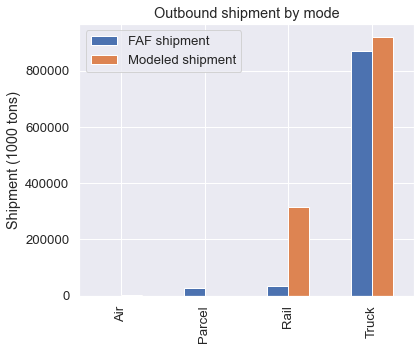

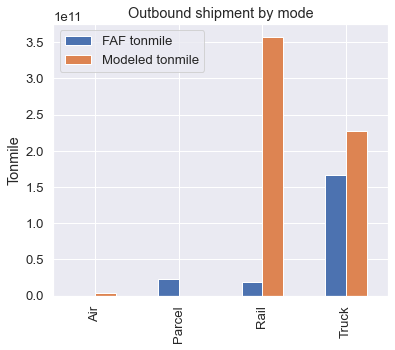

In [10]:
# plot shipment production by mode choice
model_to_FAF_mapping = {'For-hire Truck':'Truck', 
                      'Private Truck': 'Truck', 
                      'Rail/IMX': 'Rail', 
                      'Air':'Air', 
                      'Parcel':'Parcel'}
modeled_bay_area_outflow.loc[:, 'mode_def'] = modeled_bay_area_outflow.loc[:, 'mode_choice'].map(model_to_FAF_mapping)
    
agg_faf_outflow_by_mode = bay_area_outflow.groupby(['mode_def'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_outflow_by_mode = agg_faf_outflow_by_mode.reset_index()

agg_modeled_outflow_by_mode = modeled_bay_area_outflow.groupby(['mode_def'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_outflow_by_mode = agg_modeled_outflow_by_mode.reset_index()
compare_outflow_by_mode = pd.merge(agg_faf_outflow_by_mode, agg_modeled_outflow_by_mode, 
                                         on = ['mode_def'], how = 'left')

compare_outflow_by_mode.head(5)
compare_outflow_by_mode.columns = ['mode_def', 'FAF shipment', 'FAF tonmile',                                       
                                  'Modeled shipment', 'Modeled tonmile']
compare_outflow_by_mode = compare_outflow_by_mode.loc[compare_outflow_by_mode['mode_def'] != 'Other']
# compare_outflow_by_mode = compare_outflow_by_mode.rename(columns={shipment_load_attr:'FAF shipment', 
#                                                                               'ShipmentLoad':'modeled shipment',
#                                                                              'wgted_wght_ton_th':'CFS shipment'})
compare_outflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF shipment', 'Modeled shipment'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Outbound shipment by mode')

plt.xlabel('')
plt.ylabel('Shipment (1000 tons)')
plt.legend(loc=2)
plt.savefig('Plot_aus_2040/' + 'outflow_shipment_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()


compare_outflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF tonmile', 'Modeled tonmile'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Outbound shipment by mode')

plt.xlabel('')
plt.ylabel('Tonmile')
plt.legend(loc=2)
plt.savefig('Plot_aus_2040/' + 'outflow_tonmile_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_outflow_by_mode.to_csv(c.output_dir + 'outflow_shipment_by_mode_comparison.csv')

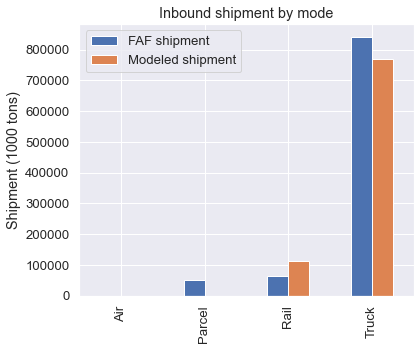

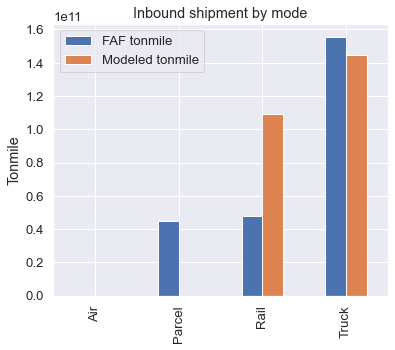

In [11]:
# plot shipment attraction by mode choice

modeled_bay_area_inflow.loc[:, 'mode_def'] = modeled_bay_area_inflow.loc[:, 'mode_choice'].map(model_to_FAF_mapping)
    
agg_faf_inflow_by_mode = bay_area_inflow.groupby(['mode_def'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_inflow_by_mode = agg_faf_inflow_by_mode.reset_index()

agg_modeled_inflow_by_mode = modeled_bay_area_inflow.groupby(['mode_def'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_inflow_by_mode = agg_modeled_inflow_by_mode.reset_index()
compare_inflow_by_mode = pd.merge(agg_faf_inflow_by_mode, agg_modeled_inflow_by_mode, 
                                         on = ['mode_def'], how = 'left')

compare_inflow_by_mode.head(5)
compare_inflow_by_mode.columns = ['mode_def', 'FAF shipment', 'FAF tonmile',                                       
                                  'Modeled shipment', 'Modeled tonmile']

compare_inflow_by_mode = compare_inflow_by_mode.loc[compare_inflow_by_mode['mode_def'] != 'Other']
# compare_outflow_by_mode = compare_outflow_by_mode.rename(columns={shipment_load_attr:'FAF shipment', 
#                                                                               'ShipmentLoad':'modeled shipment',
#                                                                              'wgted_wght_ton_th':'CFS shipment'})
compare_inflow_by_mode.plot(x= 'mode_def', 
                            y = ['FAF shipment', 'Modeled shipment'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Inbound shipment by mode')

plt.xlabel('')
plt.ylabel('Shipment (1000 tons)')
plt.legend(loc=2)
plt.savefig('Plot_aus_2040/' + 'inflow_shipment_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()


compare_inflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF tonmile', 'Modeled tonmile'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Inbound shipment by mode')

plt.xlabel('')
plt.ylabel('Tonmile')
plt.legend(loc=2)
plt.savefig('Plot_aus_2040/' + 'inflow_tonmile_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_inflow_by_mode.to_csv(c.output_dir + 'inflow_shipment_by_mode_comparison.csv')

   orig_FAFID orig_FAFNAME   ShipmentLoad
0         481       Austin   83050.328102
1         488  San Antonio  152976.395194
2         489   Rest of TX  999397.405318


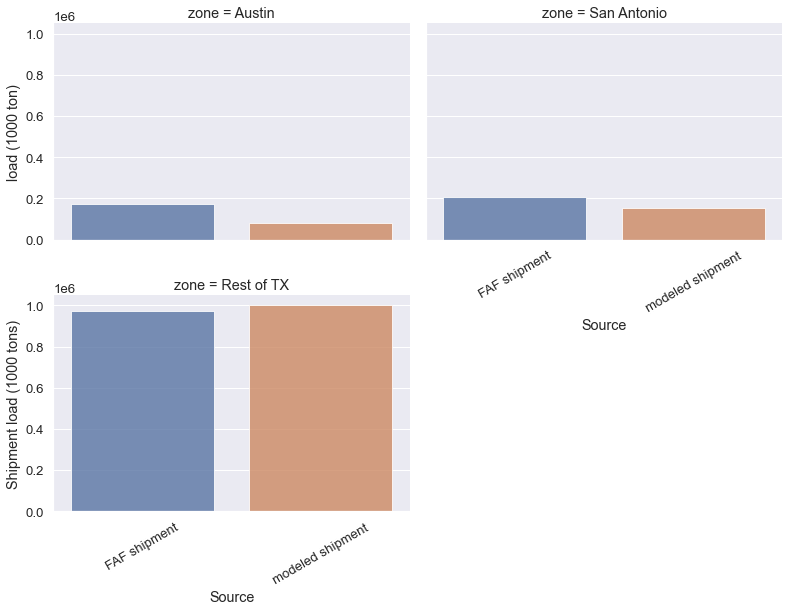

In [12]:
# plot shipment comparison by origin FAF zone and commodity group
agg_faf_outflow_by_zone = bay_area_outflow.groupby(['dms_orig'])[[shipment_load_attr]].sum()
agg_faf_outflow_by_zone = agg_faf_outflow_by_zone.reset_index()
agg_modeled_outflow_by_zone = modeled_bay_area_outflow.groupby(['orig_FAFID', 'orig_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_outflow_by_zone = agg_modeled_outflow_by_zone.reset_index()
print(agg_modeled_outflow_by_zone)
                                                                      
compare_outflow_by_zone = pd.merge(agg_faf_outflow_by_zone, agg_modeled_outflow_by_zone, 
                                         left_on = ['dms_orig'], right_on = ['orig_FAFID'], how = 'left')
compare_outflow_by_zone = compare_outflow_by_zone.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                              'ShipmentLoad':'modeled shipment'})
compare_outflow_by_zone = pd.melt(compare_outflow_by_zone, 
                                    id_vars=['dms_orig', 'orig_FAFID', 'orig_FAFNAME'], 
                                    value_vars=['FAF shipment', 'modeled shipment'], 
                                    var_name = 'Source', ignore_index=False)
# print(compare_outflow_by_zone.head(5))

compare_outflow_by_zone = compare_outflow_by_zone.rename(columns = {'orig_FAFNAME': 'zone',
                                                                   'value': 'load (1000 ton)'})
ax = sns.catplot(
    data= compare_outflow_by_zone, kind="bar",
    x="Source", y="load (1000 ton)", col = 'zone', col_wrap = 2,
    alpha=.8, height=4, aspect=1.4
)
ax.set_xticklabels(rotation=30) 
plt.savefig('Plot_aus_2040/outflow_shipment_by_zone_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.ylabel('Shipment load (1000 tons)')
plt.show()
compare_outflow_by_zone.to_csv(c.output_dir + 'compare_outflow_by_zone_cfs_dded.csv', sep = ',')

   dest_FAFID dest_FAFNAME   ShipmentLoad
0         481       Austin  123734.161529
1         488  San Antonio  154694.039338
2         489   Rest of TX  605713.727942


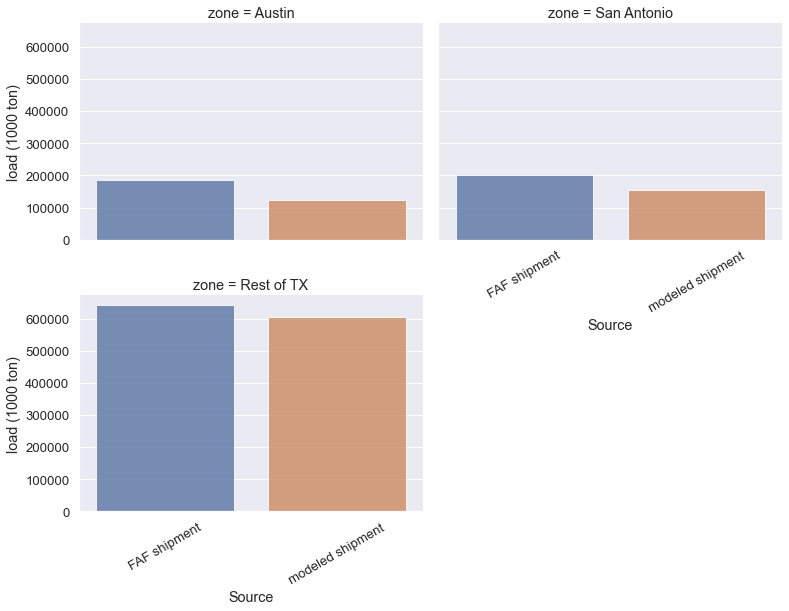

In [13]:
# plot shipment comparison by origin FAF zone and commodity group
agg_faf_inflow_by_zone = bay_area_inflow.groupby(['dms_dest'])[[shipment_load_attr]].sum()
agg_faf_inflow_by_zone = agg_faf_inflow_by_zone.reset_index()

agg_modeled_inflow_by_zone = modeled_bay_area_inflow.groupby(['dest_FAFID', 'dest_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_inflow_by_zone = agg_modeled_inflow_by_zone.reset_index()
print(agg_modeled_inflow_by_zone)
                                                                      
compare_inflow_by_zone = pd.merge(agg_faf_inflow_by_zone, agg_modeled_inflow_by_zone, 
                                         left_on = ['dms_dest'], right_on = ['dest_FAFID'], how = 'left')

compare_inflow_by_zone = compare_inflow_by_zone.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                              'ShipmentLoad':'modeled shipment'})
compare_inflow_by_zone = pd.melt(compare_inflow_by_zone, 
                                        id_vars=['dms_dest', 'dest_FAFID', 'dest_FAFNAME'], 
                                        value_vars=['FAF shipment', 'modeled shipment'], 
                                        var_name = 'Source', ignore_index=False)
# print(compare_inflow_by_zone.head(5))
compare_inflow_by_zone = compare_inflow_by_zone.rename(columns = {'dest_FAFNAME': 'zone',
                                                                   'value': 'load (1000 ton)'})
ax = sns.catplot(
    data= compare_inflow_by_zone, kind="bar",
    x="Source", y="load (1000 ton)", col = 'zone', col_wrap = 2,
    alpha=.8, height=4, aspect=1.4
)
ax.set_xticklabels(rotation=30) 
plt.savefig('Plot_aus_2040/inflow_shipment_by_zone_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_inflow_by_zone.to_csv(c.output_dir + 'compare_inflow_by_zone_cfs_dded.csv', sep = ',')

In this section, we will compare the shipment distribution (O-D flow) among FAF data, CFS data and model output. Two types of comparisons will be generated in this process:

    - Shipment comparison by origin/destination (showing top 20 origins/destinations)
    - Comparison of shipment distance distributions


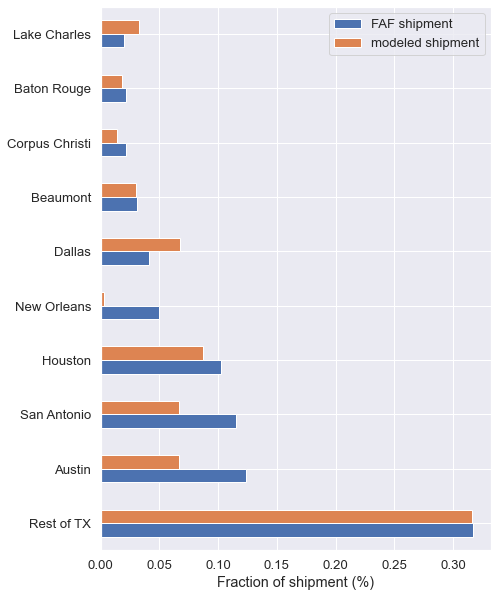

In [14]:
# plot outflow distance and tonnage distribution
nzones = 10
agg_faf_outflow_by_destination = bay_area_outflow.groupby(['dms_dest'])[[shipment_load_attr]].sum()
agg_faf_outflow_by_destination = agg_faf_outflow_by_destination.reset_index()
agg_modeled_outflow_destination = modeled_bay_area_outflow.groupby(['dest_FAFID', 'dest_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_outflow_destination = agg_modeled_outflow_destination.reset_index()

                                                                      
compare_outflow_by_destination = pd.merge(agg_faf_outflow_by_destination, agg_modeled_outflow_destination, 
                                         left_on = ['dms_dest'], right_on = ['dest_FAFID'], how = 'left')


compare_outflow_by_destination = \
compare_outflow_by_destination.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                                'ShipmentLoad':'modeled shipment'})
compare_outflow_by_destination.loc[:, 'FAF shipment'] = \
compare_outflow_by_destination.loc[:, 'FAF shipment'] / compare_outflow_by_destination.loc[:, 'FAF shipment'].sum()
compare_outflow_by_destination.loc[:, 'modeled shipment'] = \
compare_outflow_by_destination.loc[:, 'modeled shipment'] / compare_outflow_by_destination.loc[:, 'modeled shipment'].sum()

# sns.scatterplot(data=compare_outflow_by_destination, x="FAF_shipment", y="modeled_shipment")
# plot load assignment (top 20 zones)
compare_outflow_by_destination = compare_outflow_by_destination.sort_values('FAF shipment', ascending = False)
compare_outflow_by_destination_to_plot = compare_outflow_by_destination.head(nzones)
compare_outflow_by_destination_to_plot.plot.barh(x='dest_FAFNAME', y=['FAF shipment', 'modeled shipment'], 
                                         figsize = (7,10), rot = 0)
plt.xlabel('Fraction of shipment (%)')
plt.ylabel('')
plt.savefig('Plot_aus_2040/percent_outflow_load_comparison_cfs_added.png', bbox_inches = 'tight', dpi = 200)
plt.show()


In [17]:
# Generate distance and tonnage distribution by commodity groups and destinations
agg_faf_outflow_by_destination = bay_area_outflow.groupby(['dms_dest', 'SCTG_Group', \
                                                           'SCTG_Name'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_outflow_by_destination = agg_faf_outflow_by_destination.reset_index()
agg_modeled_outflow_destination = modeled_bay_area_outflow.groupby(['dest_FAFID', 'dest_FAFNAME', \
                                                                    'SCTG_Group', 'SCTG_Name'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_outflow_destination = agg_modeled_outflow_destination.reset_index()

agg_cfs_outflow_destination = cfs_outflow.groupby(['DEST_NAME','SCTG_Group', 'commodity'])[['wgted_wght_ton_th', 'tonmile']].sum()
agg_cfs_outflow_destination = agg_cfs_outflow_destination.reset_index()

compare_outflow_by_destination = pd.merge(agg_faf_outflow_by_destination, agg_modeled_outflow_destination, 
                                         left_on = ['dms_dest', 'SCTG_Group', 'SCTG_Name'], 
                                          right_on = ['dest_FAFID', 'SCTG_Group', 'SCTG_Name'], how = 'left')
compare_outflow_by_destination = pd.merge(compare_outflow_by_destination, agg_cfs_outflow_destination, 
                                         left_on = ['dest_FAFNAME', 'SCTG_Group', 'SCTG_Name'], 
                                          right_on = ['DEST_NAME', 'SCTG_Group', 'commodity'], how = 'left')

compare_outflow_by_destination = compare_outflow_by_destination.rename(columns={shipment_load_attr:'FAF_shipment',
                                                                                shipment_tonmile_attr:'FAF_tonmile',
                                                                                'ShipmentLoad':'modeled_shipment',
                                                                               'tmiles': 'modeled_tonmile',
                                                                               'wgted_wght_ton_th': 'CFS_shipment', 
                                                                                'tonmile':'CFS_tonmile'})
compare_outflow_by_destination.loc[:, 'FAF_avg_dist'] = 1000 * compare_outflow_by_destination.loc[:, 'FAF_tonmile'] / \
compare_outflow_by_destination.loc[:, 'FAF_shipment'] 
compare_outflow_by_destination.loc[:, 'CFS_avg_dist'] = compare_outflow_by_destination.loc[:, 'CFS_tonmile'] / \
compare_outflow_by_destination.loc[:, 'CFS_shipment'] 
compare_outflow_by_destination.loc[:, 'Modeled_avg_dist'] = compare_outflow_by_destination.loc[:, 'modeled_tonmile'] / \
compare_outflow_by_destination.loc[:, 'modeled_shipment'] / 1000 
compare_outflow_by_destination.loc[:, 'modeled_tonmile'] /= 1000000 # 1 million tmile
compare_outflow_by_destination.to_csv(c.output_dir + 'compare_distribution_by_destination_cargo.csv', 
                                      sep = ',', index = False)


interm_food


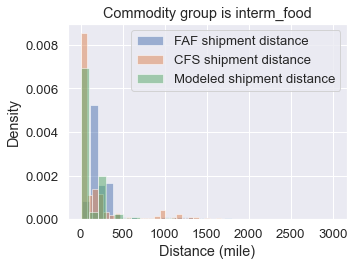

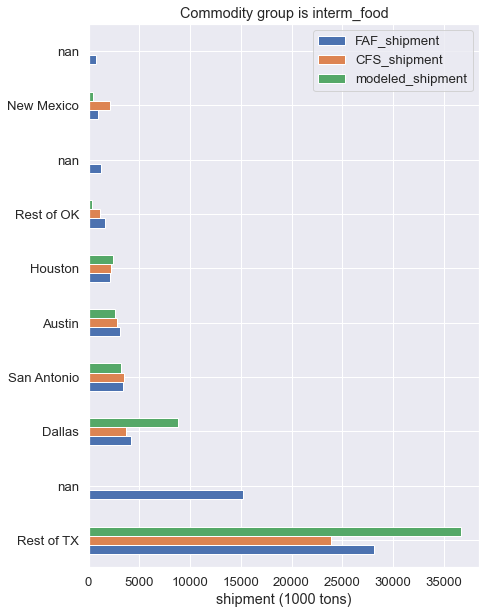

bulk


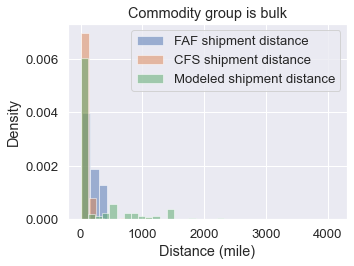

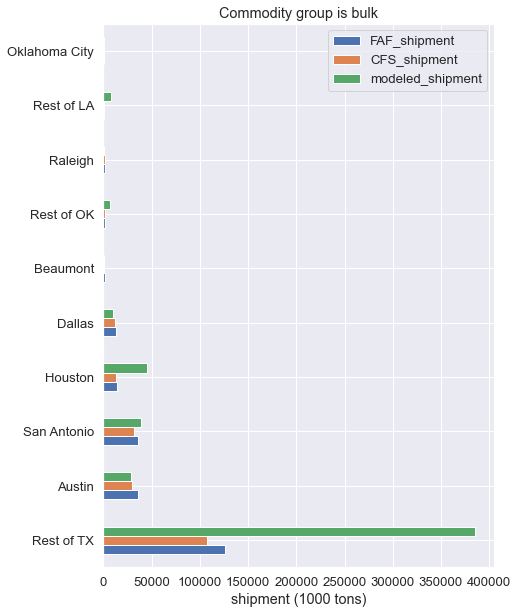

mfr_goods


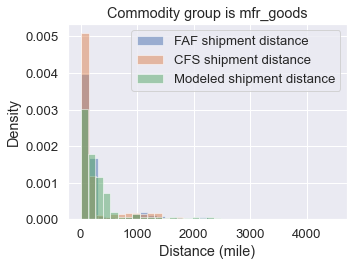

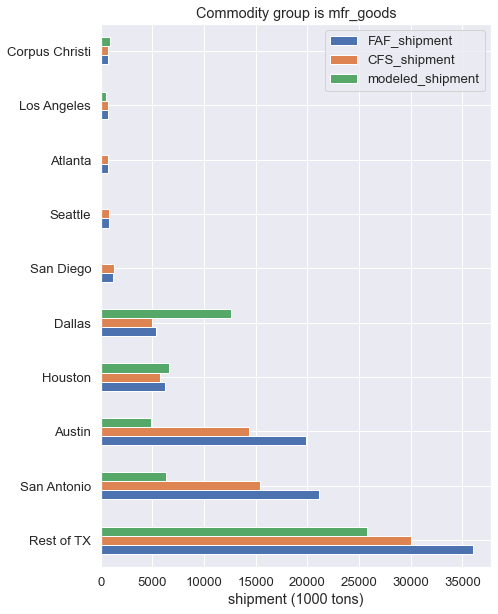

fuel_fert


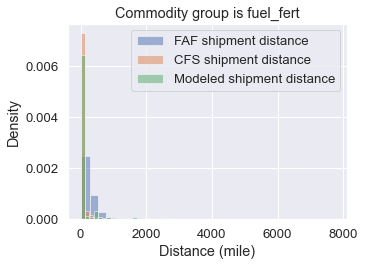

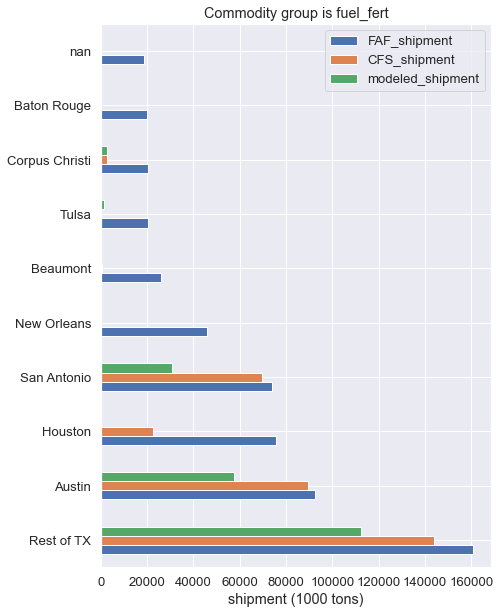

other


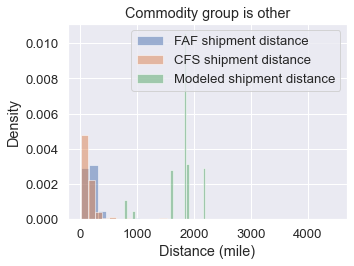

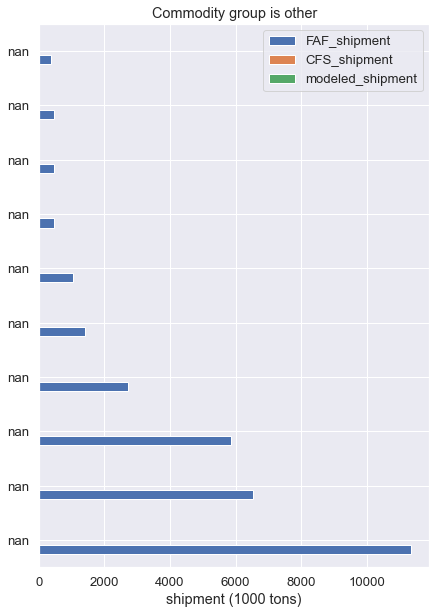

In [18]:
# plot outflow distance and tonnage distribution by commodity groups
nzones = 10
for sctg in sctg_names:
    print(sctg)
    plt.figure(figsize=(5,3.6))
    bay_area_outflow_by_sctg = bay_area_outflow.loc[bay_area_outflow['SCTG_Name'] == sctg]
    bay_area_outflow_by_sctg['Distance'].plot(kind = "hist", weights = bay_area_outflow_by_sctg[shipment_load_attr], 
                                      alpha = 0.5, bins = 30, density=True)
    cfs_outflow_by_sctg = cfs_outflow.loc[cfs_outflow['commodity'] == sctg]
    cfs_outflow_by_sctg['SHIPMT_DIST_GC'].plot(kind = "hist", weights = cfs_outflow_by_sctg['wgted_wght_ton_th'], 
                                      alpha = 0.5, bins = 30, density=True)
    modeled_bay_area_outflow_by_sctg = modeled_bay_area_outflow.loc[modeled_bay_area_outflow['SCTG_Name'] == sctg]
    modeled_bay_area_outflow_by_sctg['Distance'].plot(kind="hist", weights = modeled_bay_area_outflow_by_sctg['ShipmentLoad'], 
                                              alpha =0.5, bins = 30, density=True)
    plt.legend(['FAF shipment distance', 'CFS shipment distance', 'Modeled shipment distance'])
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.title('Commodity group is ' + sctg)
    plt.savefig('plot/outflow_distance_comparison_' + sctg + '_cfs_added.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    # plot load assignment (top 10 zones)
    compare_outflow_by_destination_sctg = compare_outflow_by_destination.loc[compare_outflow_by_destination['SCTG_Name'] == sctg]
    compare_outflow_by_destination_sctg = compare_outflow_by_destination_sctg.sort_values('FAF_shipment', ascending = False)
    compare_outflow_by_destination_to_plot = compare_outflow_by_destination_sctg.head(nzones)
    compare_outflow_by_destination_to_plot.plot.barh(x='dest_FAFNAME', y=['FAF_shipment','CFS_shipment', 'modeled_shipment'], 
                                             figsize = (7,10), rot = 0)
    plt.xlabel('shipment (1000 tons)')
    plt.ylabel('')
    plt.title('Commodity group is ' + sctg)           
    plt.savefig('plot/outflow_load_comparison_' + sctg + '_cfs_added.png', bbox_inches = 'tight', dpi = 200)
    plt.show()

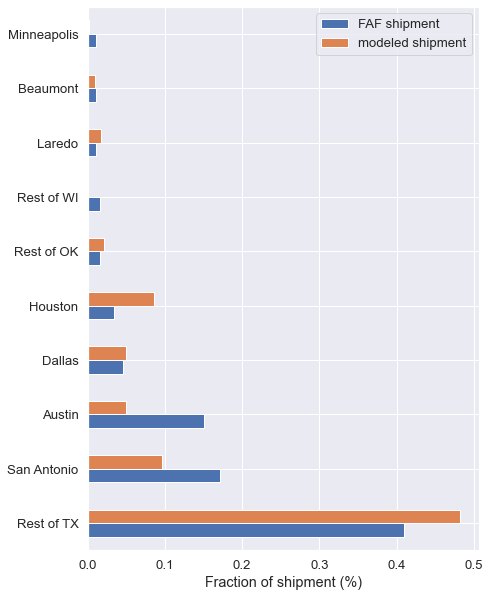

In [15]:
# plot inflow distance and tonnage distribution
nzones = 10
agg_faf_inflow_by_origin = bay_area_inflow.groupby(['dms_orig'])[[shipment_load_attr]].sum()
agg_faf_inflow_by_origin = agg_faf_inflow_by_origin.reset_index()
agg_modeled_inflow_origin = modeled_bay_area_inflow.groupby(['orig_FAFID', 'orig_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_inflow_origin = agg_modeled_inflow_origin.reset_index()

                                                                      
compare_inflow_by_origin = pd.merge(agg_faf_inflow_by_origin, agg_modeled_inflow_origin, 
                                         left_on = ['dms_orig'], right_on = ['orig_FAFID'], how = 'left')



compare_inflow_by_origin = compare_inflow_by_origin.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                                'ShipmentLoad':'modeled shipment'})


compare_inflow_by_origin.loc[:, 'FAF shipment'] = compare_inflow_by_origin.loc[:, 'FAF shipment'] / compare_inflow_by_origin.loc[:, 'FAF shipment'].sum()
compare_inflow_by_origin.loc[:, 'modeled shipment'] = compare_inflow_by_origin.loc[:, 'modeled shipment'] / compare_inflow_by_origin.loc[:, 'modeled shipment'].sum()

# plot load assignment (top 20 zones)
compare_inflow_by_origin = compare_inflow_by_origin.sort_values('FAF shipment', ascending = False)
compare_inflow_by_origin_to_plot = compare_inflow_by_origin.head(nzones)
compare_inflow_by_origin_to_plot.plot.barh(x='orig_FAFNAME', y=['FAF shipment', 'modeled shipment'], 
                                         figsize = (7,10), rot = 0)
plt.xlabel('Fraction of shipment (%)')
plt.ylabel('')
plt.savefig('Plot_aus_2040/percent_inflow_load_comparison_cfs_added.png', bbox_inches = 'tight', dpi = 200)
plt.show()


In [19]:
# Generate distance and tonnage distribution by commodity groups and origins
agg_faf_inflow_by_origin = bay_area_inflow.groupby(['dms_orig', 'SCTG_Group', \
                                                           'SCTG_Name'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_inflow_by_origin = agg_faf_inflow_by_origin.reset_index()
agg_modeled_inflow_origin = modeled_bay_area_inflow.groupby(['orig_FAFID', 'orig_FAFNAME', \
                                                                    'SCTG_Group', 'SCTG_Name'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_inflow_origin = agg_modeled_inflow_origin.reset_index()

agg_cfs_inflow_origin = cfs_inflow.groupby(['ORIG_NAME','SCTG_Group', 'commodity'])[['wgted_wght_ton_th', 'tonmile']].sum()
agg_cfs_inflow_origin = agg_cfs_inflow_origin.reset_index()

compare_inflow_by_origin = pd.merge(agg_faf_inflow_by_origin, agg_modeled_inflow_origin, 
                                         left_on = ['dms_orig', 'SCTG_Group', 'SCTG_Name'], 
                                          right_on = ['orig_FAFID', 'SCTG_Group', 'SCTG_Name'], how = 'left')
compare_inflow_by_origin = pd.merge(compare_inflow_by_origin, agg_cfs_inflow_origin, 
                                         left_on = ['orig_FAFNAME', 'SCTG_Group', 'SCTG_Name'], 
                                          right_on = ['ORIG_NAME', 'SCTG_Group', 'commodity'], how = 'left')

compare_inflow_by_origin = compare_inflow_by_origin.rename(columns={shipment_load_attr:'FAF_shipment',
                                                                                shipment_tonmile_attr:'FAF_tonmile',
                                                                                'ShipmentLoad':'modeled_shipment',
                                                                               'tmiles': 'modeled_tonmile',
                                                                               'wgted_wght_ton_th': 'CFS_shipment', 
                                                                                'tonmile':'CFS_tonmile'})
compare_inflow_by_origin.loc[:, 'FAF_avg_dist'] = 1000 * compare_inflow_by_origin.loc[:, 'FAF_tonmile'] / \
compare_inflow_by_origin.loc[:, 'FAF_shipment'] 
compare_inflow_by_origin.loc[:, 'CFS_avg_dist'] = compare_inflow_by_origin.loc[:, 'CFS_tonmile'] / \
compare_inflow_by_origin.loc[:, 'CFS_shipment'] 
compare_inflow_by_origin.loc[:, 'Modeled_avg_dist'] = compare_inflow_by_origin.loc[:, 'modeled_tonmile'] / \
compare_inflow_by_origin.loc[:, 'modeled_shipment'] / 1000 
compare_inflow_by_origin.loc[:, 'modeled_tonmile'] /= 1000000 # 1 million tmile
compare_inflow_by_origin.to_csv(c.output_dir + 'compare_distribution_by_origin_cargo.csv', 
                                      sep = ',', index = False)

interm_food


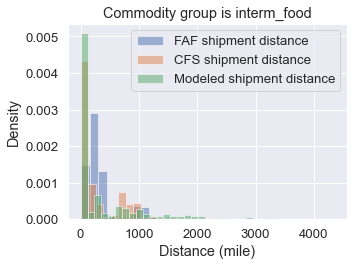

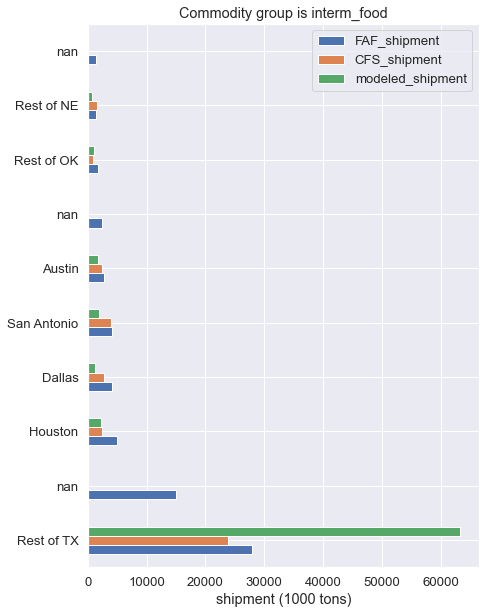

bulk


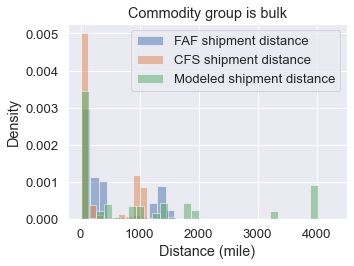

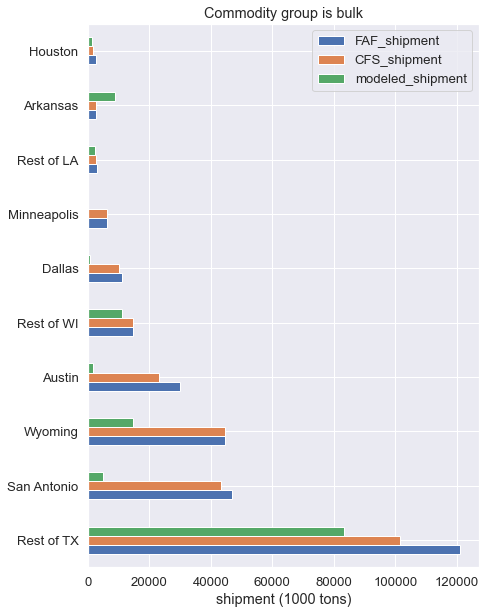

mfr_goods


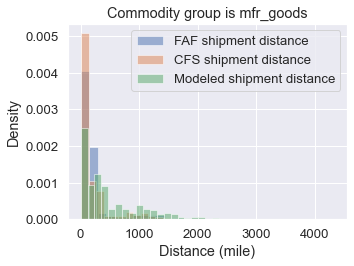

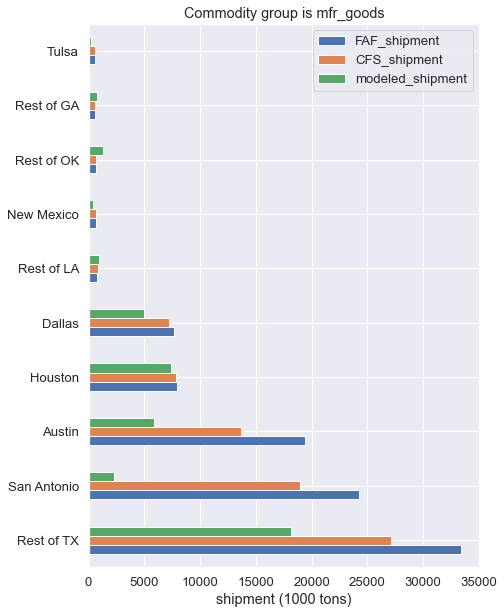

fuel_fert


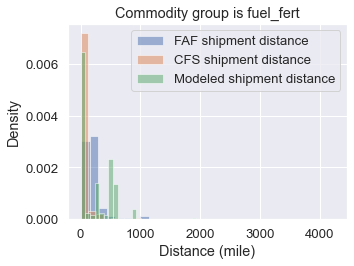

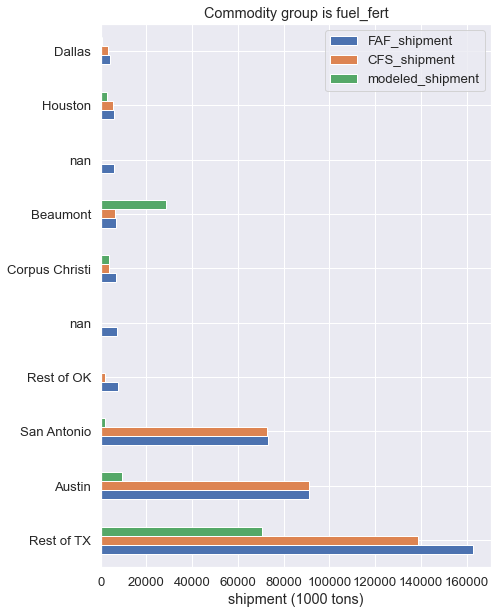

other


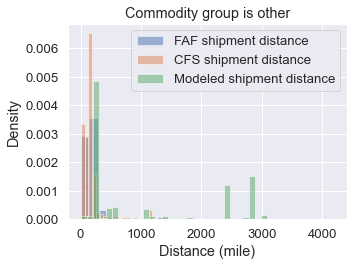

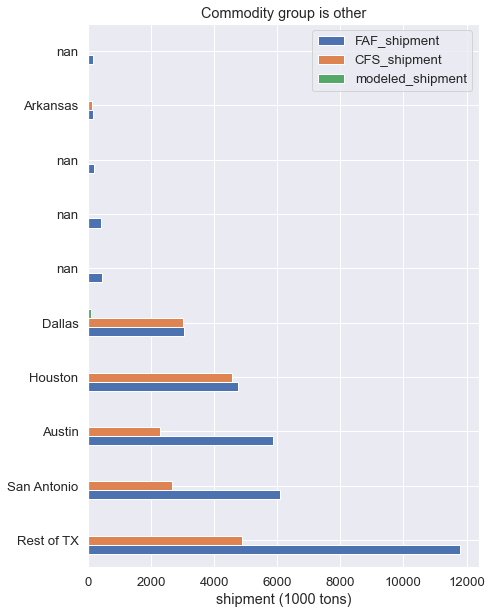

In [20]:
# plot inflow distance and tonnage distribution by commodity groups
for sctg in sctg_names:
    print(sctg)
    plt.figure(figsize=(5,3.6))
    bay_area_inflow_by_sctg = bay_area_inflow.loc[bay_area_inflow['SCTG_Name'] == sctg]
    bay_area_inflow_by_sctg['Distance'].plot(kind = "hist", weights = bay_area_inflow_by_sctg[shipment_load_attr], 
                                      alpha = 0.5, bins = 30, density=True)
    cfs_inflow_by_sctg = cfs_inflow.loc[cfs_inflow['commodity'] == sctg]
    cfs_inflow_by_sctg['SHIPMT_DIST_GC'].plot(kind = "hist", weights = cfs_inflow_by_sctg['wgted_wght_ton_th'], 
                                      alpha = 0.5, bins = 30, density=True)
    modeled_bay_area_inflow_by_sctg = modeled_bay_area_inflow.loc[modeled_bay_area_inflow['SCTG_Name'] == sctg]
    modeled_bay_area_inflow_by_sctg['Distance'].plot(kind="hist", weights = modeled_bay_area_inflow_by_sctg['ShipmentLoad'], 
                                              alpha =0.5, bins = 30, density=True)
    plt.legend(['FAF shipment distance', 'CFS shipment distance', 'Modeled shipment distance'])
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.title('Commodity group is ' + sctg)
    plt.savefig('plot/inflow_distance_comparison_' + sctg + '_cfs_added.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    # plot load assignment (top 10 zones)
    compare_inflow_by_origin_sctg = compare_inflow_by_origin.loc[compare_inflow_by_origin['SCTG_Name'] == sctg]
    compare_inflow_by_origin_sctg = compare_inflow_by_origin_sctg.sort_values('FAF_shipment', ascending = False)
    compare_inflow_by_origin_sctg_to_plot = compare_inflow_by_origin_sctg.head(nzones)
    compare_inflow_by_origin_sctg_to_plot.plot.barh(x='orig_FAFNAME', y=['FAF_shipment','CFS_shipment', 'modeled_shipment'], 
                                             figsize = (7,10), rot = 0)
    plt.xlabel('shipment (1000 tons)')
    plt.ylabel('')
    plt.title('Commodity group is ' + sctg)           
    plt.savefig('plot/inflow_load_comparison_' + sctg + '_cfs_added.png', bbox_inches = 'tight', dpi = 200)
    plt.show()